# Tourism Ecometric - Group 7

**Meng Forrest,
Michiels Garrett, 
Mitchell Timothy, 
Peter Gabriel,
Pickett Daniel**


## Intro


##### Todo - Begin with a markdown cell that defines the concept being studied and explains why it is interesting.

For the 2nd mini project, our group created a tourism ecometric using a weighted sum of data from three of the provided data sets: google places, airbnb, and yelp reviews. Tourism is composed of people visiting, staying, and experiencing places that are new to them. Using these three data sets we can measure the tourism in a certain area. The googe places data set allows us to identify points of interest in an area that tourists are likely to visit and be around such as acquariums, museums, and art gallerys. The yelp review dataset allows us to count the number of restaurants listed on yelp in a certain area. The Airbnb dataset allows for a measure of mostly temporary short term housing in an area. By combining these metrics into one ecometric for tourism, we have a much better measure of all of the tourist related activity than could be measured using any single one.

## 1. Read in Data

We first read in the provided CSV data for google places, airbnb listings, and yelp restaurants. We use the csv's provided as in from the assignment. They are not modified at all before reading them in.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# install from source 
# https://geopandas.org/getting_started/install.html
# !pip install geopandas
# import geopandas

In [3]:
places_df = pd.read_csv('data/GooglePlaces.csv', low_memory=False)
airbnb_df = pd.read_csv('data/AIRBNB_Listings.csv', low_memory=False)
yelp_df = pd.read_csv('data/YELP_Restaurants.csv', low_memory=False)

## 2 / 3. Identifying and Aggregating Columns of Interest

### Columns of interest - Places

The places dataset 'Tag_1' column gives a description of each place. To identify tourism we will filter and only count specific places which we have identified as relating to tourism. This includes art galleries, museums and more. We will avoid banks, doctors, and other non tourist related buildings. When someone visits a new place they are highly unlikely to visit these or if they do it is much less common.

In [4]:
places_df.columns

Index(['GIS_ID', 'place_id', 'name', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4',
       'Tag_5', 'Tag_6', 'Tag_7', 'Tag_8', 'Tag_9', 'Tag_10', 'vicinity', 'X',
       'Y', 'Blk_ID_10', 'CT_ID_10'],
      dtype='object')

To decide which locations available can be used for tourism, we display a list of all the possible locations.

In [5]:
places_df['Tag_1'].unique()

array(['restaurant', 'doctor', 'synagogue', 'general_contractor',
       'clothing_store', 'health', 'bakery', 'bank', 'gym', 'bar',
       'beauty_salon', 'insurance_agency', 'atm', 'physiotherapist',
       'pharmacy', 'grocery_or_supermarket', 'finance', 'shoe_store',
       'local_government_office', 'moving_company', 'car_dealer', 'spa',
       'cafe', 'hair_care', 'store', 'fire_station', 'dentist',
       'accounting', 'lawyer', 'real_estate_agency', 'home_goods_store',
       'laundry', 'convenience_store', 'church', 'movie_theater',
       'place_of_worship', 'parking', 'liquor_store', 'furniture_store',
       'hospital', 'travel_agency', 'embassy', 'bus_station', 'park',
       'courthouse', 'hardware_store', 'art_gallery', 'car_repair',
       'meal_delivery', 'car_rental', 'jewelry_store', 'electrician',
       'storage', 'bicycle_store', 'plumber', 'veterinary_care',
       'lodging', 'electronics_store', 'library', 'museum', 'painter',
       'food', 'night_club', 'roofi

Then we create a list of a subset of these places which relate to tourism.

- park
- acquarium
- museum
- bowling alley
- zoo
- embassy
- night club
- art gallery
- car rental

In [6]:
poi = ['park', 'aquarium', 'museum', 'bowling_alley','stadium', 'zoo', 'embassy', 'night_club', 'art_gallery', 'car_rental']

Finally for googe places, we create a dictionary which maps each census tract id to a count of the number of tourism related places found in that tract. All the census tracts start at 0. For each row, if the rows 'Tag_1' column is within our list of places of interest, we increment the count of that id, otherwise we go to the next row. Then we turn the dictionary into a series to be used to create the ecometric

In [7]:
places_counts = {}

# work from a copy of the dataframe to not modify the source
temp_places_df = places_df.copy()
temp_places_df = temp_places_df.dropna(subset=['CT_ID_10'])
temp_places_df = temp_places_df.reset_index()

for r in range(temp_places_df.shape[0]):
    
    # try catch will help with nan and other invalid columns, in this case we pass
    try:
        tract = temp_places_df.at[r, 'CT_ID_10']

        # adjust improperly formatted tracts
        if str(tract).endswith('.0'):
            tract = str(tract)[:-2]
            tract = int(tract)

        tract = int(tract)

        if tract not in places_counts:
            places_counts[tract] = 0

        # row is place of tourism
        if temp_places_df.at[r, 'Tag_1'] in poi:    
            places_counts[tract] += 1
    except:
        pass

places_count = pd.Series(places_counts)
places_count = places_count.rename("counts")
places_count = places_count.rename_axis("CT_ID_10")
places_count

CT_ID_10
25025000802    13
25025040801     5
25025071101     2
25025060600    19
25025040600     2
               ..
25025060200     0
25025980700     0
25025981000     2
25025061101     0
25025981502     0
Name: counts, Length: 181, dtype: int64

### Columns of interest - Airbnb

For airbnb data, we first acknowledged that because we do not have a complete list of all airbnb listings, but only a subset, we must be careful with how we use the data. Therefore we stuck with simply counting the number of bed spaces in each tract. We are making the assumption that, despite not having every listing, tracts more popular with tourism will still have a net higher count of bed spaces than much less popular areas. This also ensures we are weighting airbnbs that can hold more people higher than smaller capacity airbnbs as they will house more people in the area.

In [8]:
airbnb_df.columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules', 'id',
       'Year', 'Month', 'listing_url', 'picture_url', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'requires_license',
       'license', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'is_business_travel_ready', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_su

We create a series grouped by each tract where the value associated with that tract is the sum of availble beds

In [9]:
bnb_count = airbnb_df.groupby(by=['CT_ID_10']).count()['name']
bnb_count = bnb_count.rename("counts")
bnb_count

CT_ID_10
25017342400     13
25017350103      1
25017350104      1
25017350400      3
25017350500      5
              ... 
25025981202     38
25025981300     47
25025981501    205
25025981700     18
25025981800    451
Name: counts, Length: 249, dtype: int64

### Columns of interest - Yelp

For yelp we count the number of restuarants in each tract. We use this to get a general idea of how many options would be availble to a person visting a certain location. An area with a lot of resaurants could be more popular for tourism. We haven't distinguished based on price because both inexpensive and expensive restaurants could be popular depending on the type of tourist.

In [10]:
yelp_df.columns

Index(['restaurant_name', 'restaurant_ID', 'restaurant_address',
       'restaurant_tag', 'rating', 'price', 'review_number', 'unique_reviewer',
       'reviews_Jan_19', 'reviews_Feb_19', 'reviews_Mar_19', 'reviews_Apr_19',
       'reviews_May_19', 'reviews_Jun_19', 'reviews_Jul_19', 'reviews_Aug_19',
       'reviews_Jan_20', 'reviews_Feb_20', 'reviews_Mar_20', 'reviews_Apr_20',
       'reviews_May_20', 'reviews_Jun_20', 'reviews_Jul_20', 'reviews_Aug_20',
       'restaurant_neighborhood', 'GIS_ID', 'CT_ID_10'],
      dtype='object')

We create a series grouped by each tract where the value associated with that tract is the count of restaurants.

In [11]:
res_count = yelp_df.groupby(by=['CT_ID_10']).count()['restaurant_name']
res_count = res_count.rename("counts")
res_count

CT_ID_10
25025000100    21
25025000201    12
25025000202     8
25025000301     7
25025000302     5
               ..
25025981300    60
25025981501     1
25025981600     1
25025981700     1
25025990101     1
Name: counts, Length: 169, dtype: int64

## 3. Joining for Ecometric

With three series representing housing, restaurants, and tourist locations, we can now join these into creating our tourism ecometric.

All of the series are converted into a dataframe and then joined on the 'CT_ID_10' column using an inner join. This means to construct our final ecometric we will only includes tracts that have data from all three of our series. Although we may miss out on a few tracts, all of the tracts that we do create an ecometric for we know are backed by our data.

In [12]:
cols = {'airbnb':bnb_count}
bnb_df = pd.DataFrame(cols)

cols1 = {'places':places_count}
places_df = pd.DataFrame(cols1)

cols2 = {'rest':res_count}
rest_df = pd.DataFrame(cols2)

In [13]:
bnb_places = bnb_df.join(places_df, how='inner', sort=False)
combined_df = bnb_places.join(rest_df, how='inner', sort=False)
combined_df.head()

,airbnb,places,rest
CT_ID_10,,,
25025000100,961,8,21
25025000201,340,0,12
25025000202,95,0,8
25025000301,272,0,7
25025000302,325,0,5


Since each of the three seperate measurements have different units and scales, we normalize the data before creating our ecometric. This is because we don't want 323 bed spaces in a tract to count 323x more towards the ecometric than 1 restaurant. By scaling each of the columns the same they can be merged together to create our final metric.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler makes all values in a column scaled between 0-1
scaler = MinMaxScaler()

scaled_df = combined_df.copy()

# Apply to each column
scaled_df['airbnb'] = scaler.fit_transform(scaled_df['airbnb'].values.reshape(-1,1))
scaled_df['places'] = scaler.fit_transform(scaled_df['places'].values.reshape(-1,1))
scaled_df['rest'] = scaler.fit_transform(scaled_df['rest'].values.reshape(-1,1))

scaled_df.head()

,airbnb,places,rest
CT_ID_10,,,
25025000100,0.267732,0.133333,0.077519
25025000201,0.093636,0.000000,0.042636
25025000202,0.024951,0.000000,0.027132
25025000301,0.074572,0.000000,0.023256
25025000302,0.089431,0.000000,0.015504


Combined the three values, weighted equally, to create final ecometric.

In [15]:


scaled_df['ecometric'] = \
1 * scaled_df['airbnb'] +  1 * scaled_df['places'] + 1 * scaled_df['rest']

ecometric_df = scaled_df.filter(['ecometric'], axis=1)
ecometric_df

,ecometric
CT_ID_10,
25025000100,0.478585
25025000201,0.136272
25025000202,0.052083
25025000301,0.097828
25025000302,0.104935
...,...
25025981201,0.055558
25025981202,0.128739
25025981300,0.723510


## 4. Analysis / Visualizations

Text(0.5, 1.0, 'TODO')

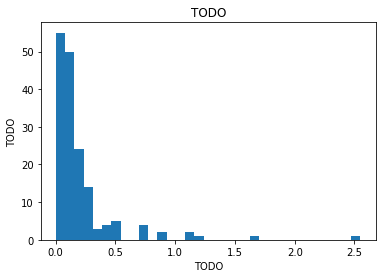

In [16]:
# can make some vis with combined_df probably
bins = int(ecometric_df.shape[0]/5)
ecometric_df_unindexed = ecometric_df.reset_index()
plt.hist(ecometric_df_unindexed['ecometric'], bins=bins)
plt.xlabel("Tourism Index")
plt.ylabel("TODO")
plt.title("TODO")


In [20]:
for col in combined_df.columns:
    print(col, '\n', combined_df[col].describe())
combined_df.corr()

airbnb 
 count     166.000000
mean      351.120482
std       400.659635
min         6.000000
25%       117.000000
50%       246.000000
75%       446.000000
max      3573.000000
Name: airbnb, dtype: float64
places 
 count    166.000000
mean       3.114458
std        7.477167
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
Name: places, dtype: float64
rest 
 count    166.000000
mean      16.030120
std       29.203243
min        1.000000
25%        4.000000
50%        9.000000
75%       16.750000
max      259.000000
Name: rest, dtype: float64


,airbnb,places,rest
airbnb,1.000000,0.481194,0.717340
places,0.481194,1.000000,0.655762
rest,0.717340,0.655762,1.000000


In [21]:
ecometric_df.describe()

,ecometric
count,166.000000
mean,0.206918
std,0.301945
min,0.002523
25%,0.066160
50%,0.123692
75%,0.195918
max,2.550000


In [18]:
# descriptive statistics or something about data, statistical tests maybe to see how each each of the three data 
# compare in their measures of tourism

### Questions

**What is the phenomenon that you are trying to measure through your newly generated variable? In other words – define your concept.**


**How do the variables you included in your measure relate to your concept of interest?**

**How did you address missing data? How much of it was there? Why did you choose this strategy?**

**What strategy did you choose to aggregate your data from record-level to neighborhood-level information? Why was this the most appropriate strategy for measuring your concept of interest?**

**What do the statistics and visualization you produced tell us about the state of disorder/gentrification/tourism/etc. across Boston neighborhoods?**

**What types of additional information or variables might have enhanced your ability to represent your chosen phenomenon through data?**